In [138]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from catboost import train
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error as rmse

In [139]:
df = pd.read_csv('Student_Performance.csv')
df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


In [140]:
df['Activities_bin'] = (df['Extracurricular Activities'] == 'Yes').astype(int)
df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Activities_bin
0,7,99,Yes,9,1,91.0,1
1,4,82,No,4,2,65.0,0
2,8,51,Yes,7,2,45.0,1
3,5,52,Yes,5,2,36.0,1
4,7,75,No,8,5,66.0,0
...,...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0,1
9996,7,64,Yes,8,5,58.0,1
9997,6,83,Yes,8,5,74.0,1
9998,9,97,Yes,7,0,95.0,1


In [141]:
df.drop('Extracurricular Activities', axis=1, inplace=True)
df

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,Activities_bin
0,7,99,9,1,91.0,1
1,4,82,4,2,65.0,0
2,8,51,7,2,45.0,1
3,5,52,5,2,36.0,1
4,7,75,8,5,66.0,0
...,...,...,...,...,...,...
9995,1,49,4,2,23.0,1
9996,7,64,8,5,58.0,1
9997,6,83,8,5,74.0,1
9998,9,97,7,0,95.0,1


In [142]:
train_x, test_x, train_y, test_y = train_test_split(df.drop(columns='Performance Index'), df['Performance Index'], test_size=0.3, random_state=42, shuffle=True)

<Axes: xlabel='Performance Index'>

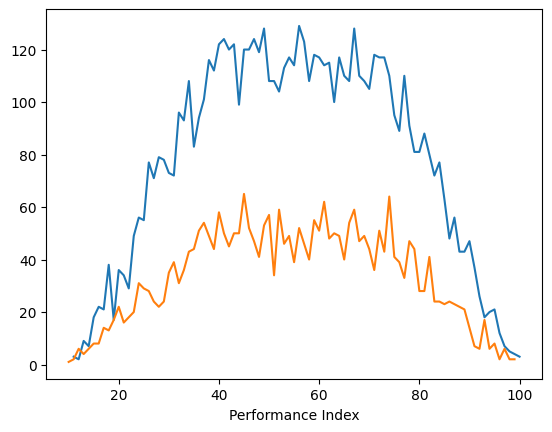

In [143]:
train_y.value_counts().sort_index().plot()
test_y.value_counts().sort_index().plot()

In [144]:
train_x.columns

Index(['Hours Studied', 'Previous Scores', 'Sleep Hours',
       'Sample Question Papers Practiced', 'Activities_bin'],
      dtype='object')

# Регрессия

In [145]:
from scipy.optimize import curve_fit 

def mapping_func(x, a, b, c, d, e, f): 
    return a + b*x['Hours Studied'] + c*x['Previous Scores'] + d*x['Sleep Hours'] + e*x['Sample Question Papers Practiced'] + f*x['Activities_bin']

args, covar = curve_fit(mapping_func, train_x, train_y)

a, b, c, d, e, f = args[0], args[1], args[2], args[3], args[4], args[5]

res_y_tr = a + b*train_x['Hours Studied'] + c*train_x['Previous Scores'] + d*train_x['Sleep Hours'] + e*train_x['Sample Question Papers Practiced'] + f*train_x['Activities_bin']
res_y_ts = a + b*test_x['Hours Studied'] + c*test_x['Previous Scores'] + d*test_x['Sleep Hours'] + e*test_x['Sample Question Papers Practiced'] + f*test_x['Activities_bin']
res_y = list(res_y_tr)+list(res_y_ts)

1.6090437564011766
0.035042002521393875


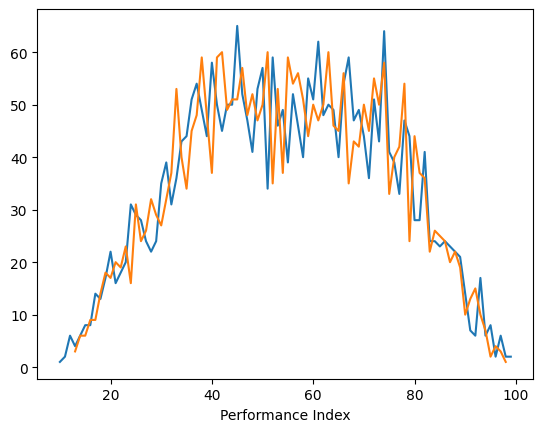

In [146]:
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape, classification_report,  roc_curve

test_y.value_counts().sort_index().plot()
pd.Series([round(i) for i in res_y_ts]).value_counts().sort_index().plot()
print(mae(test_y, res_y_ts))
print(mape(test_y, res_y_ts))

# Классификация на оценки от 1 до 5

In [147]:
from math import ceil

def get_mark(perf):
    return ceil(perf/20)

train_y = train_y.apply(get_mark)
test_y = test_y.apply(get_mark)

<Axes: xlabel='Performance Index'>

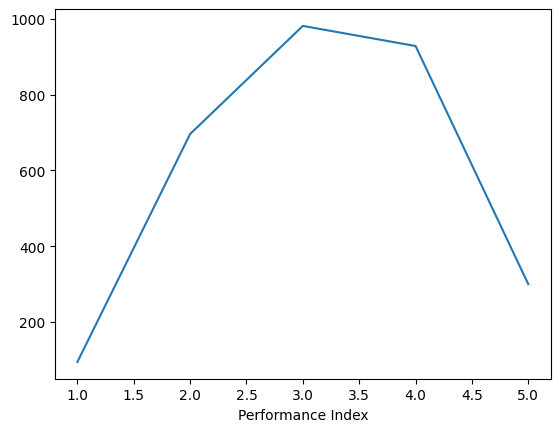

In [148]:
test_y.value_counts().sort_index().plot()

In [149]:
print(classification_report(test_y, [get_mark(i) for i in res_y_ts]))

              precision    recall  f1-score   support

           1       0.95      0.76      0.84        95
           2       0.94      0.90      0.92       696
           3       0.90      0.93      0.91       981
           4       0.92      0.92      0.92       928
           5       0.89      0.94      0.91       300

    accuracy                           0.91      3000
   macro avg       0.92      0.89      0.90      3000
weighted avg       0.92      0.91      0.91      3000



In [150]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10000)
model.fit(train_x, train_y)
model_pred = model.predict(test_x)

print(classification_report(test_y, model_pred))

              precision    recall  f1-score   support

           1       0.87      0.83      0.85        95
           2       0.93      0.90      0.92       696
           3       0.89      0.93      0.91       981
           4       0.93      0.91      0.92       928
           5       0.92      0.91      0.92       300

    accuracy                           0.91      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.91      0.91      0.91      3000



In [151]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize


model_pred_proba = model.predict_proba(test_x)
y_pred_one_hot = label_binarize([get_mark(i)-1 for i in res_y_ts], classes=np.arange(5))
roc_reg = roc_auc_score(test_y, y_pred_one_hot, average="macro", multi_class="ovr")
roc_model = roc_auc_score(test_y, model_pred_proba, average="macro", multi_class="ovr")
print(f'ROC-AUC регрессии   : {roc_reg:0.4f}')
print(f'ROC-AUC классификаци: {roc_model:0.4f}')

ROC-AUC регрессии   : 0.9324
ROC-AUC классификаци: 0.9943
